# 2 - Importing Assignments into Workforce using the ArcGIS API for Python

This is a continuation of the previous notebook that was used to configure a new Workforce Project. If you recall, we configured our Project with the following:
- 3 Assignment Types
    - Fill in Pothole
    - Sidewalk Repair
    - Paint Crosswalk
- 2 Additional Dispatchers
- 3 Workers
- Assignment Integration with Explorer for ArcGIS

Many organizations have existing data in various formats such as CSV files, SQL databases, and existing services and layers. These data may represent assets that need to be inspected, work orders that need to be completed, or some other task that needs to be assigned. In this guide, we'll demonstrate how to add assignments to a Workforce Project from various data sources.

This guide uses the ArcGIS API for Python version 1.5.1 with Python 3.6+.

### Fetching the Project
Let's import the ArcGIS API for Python and find the project we previously configured.

In [1]:
from arcgis.gis import GIS
from arcgis.apps import workforce

gis = GIS("https://arcgis.com", "workforce_scripts")
project = workforce.Project(gis.content.search("type:'Workforce Project' 'Public Works Work Orders'")[0])

Enter password: ········


### Importing Assignments From a CSV File
Suppose we have a CSV file of potholes (potholes.csv) that need to filled. We can use [pandas](https://pandas.pydata.org/) to read this file and then use the workforce module to create an assignment for each row in the file.

In [2]:
import pandas as pd
potholes_df = pd.read_csv('data/potholes.csv')
potholes_df

,Address,City,State,Description,Priority,Work_Order_ID
0,State St & W G St,San Diego,CA,Fill in the pothole on State Street near the i...,2,1
1,15th St & E St,San Diego,CA,Fill in the pothole in the middle of the inter...,2,2
2,3119 Ocean View Blvd,San Diego,CA,Fill in the pothole near the curb,2,3
3,2901 B St,San Diego,CA,Fill in the pothole on the south side,3,4
4,598 Ash St,San Diego,CA,Fill in the pothole near Domino's,2,5
5,841 N Harbor,San Diego,CA,Fill in the pothole near the curb,2,6


Let's iterate over the different potholes that need to be fixed, and create an [Assignment](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#assignment) object for it. We'll leverage the default geocoder for the organization to find the location for each assignment. It's important to note that we specify the output spatial reference to be WGS 84 Web Mercator Auxiliary Sphere (wkid: 102100), as that is what the Assignments Feature Layer expects.

In [3]:
from arcgis.geocoding import geocode

pothole_assignments = []
for _, row in potholes_df.iterrows():
    geometry = geocode(f"{row['Address']} {row['City']} {row['State']}", out_sr=102100)[0]["location"]
    pothole_assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["Address"],
            description=row["Description"],
            priority=int(row["Priority"]),
            work_order_id=row["Work_Order_ID"],
            assignment_type="Fill In Pothole",
            status="unassigned"
        )
    )

Now we'll use the [batch_add](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.managers.html#arcgis.apps.workforce.managers.AssignmentManager.batch_add) method, which is a method on the [AssignmentManager](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#assignment) class, to add all of these assignments to the Project.

In [4]:
project.assignments.batch_add(pothole_assignments)

[<Assignment 100>,
 <Assignment 101>,
 <Assignment 102>,
 <Assignment 103>,
 <Assignment 104>,
 <Assignment 105>]

### Importing from Feature Layer
Suppose our organziation has a hosted feature layer of crosswalks that need to be re-painted. We will use the ArcGIS API for Python to find this layer, query the features, and then create a new [assignment](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#assignment) for each feature. First, we'll search for the crosswalk item in our organization.

<Item title:"Crosswalk Painting" type:Feature Layer Collection owner:workforce_scripts>
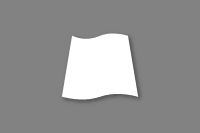

In [5]:
crosswalks_item = gis.content.search("Crosswalk Painting")[0]
crosswalks_item

Let's find all of the crosswalks that need to be painted by querying the first layer in the service. Then we'll convert the results to a spatially enabled dataframe.You can see in the table below, there are 5 crosswalks that need to be painted.

In [6]:
crosswalks_df = crosswalks_item.layers[0].query().sdf
crosswalks_df

,OBJECTID,SHAPE,description,location,priority
0,1,"{""x"": -13042100.444693483, ""y"": 3856655.475106...",The lines need to be re-painted,6th Ave & K St,3
1,2,"{""x"": -13040238.93433077, ""y"": 3856927.4834379...",The cross walks need to be re-painted,Island Ave & 24th St,3
2,3,"{""x"": -13039276.604087984, ""y"": 3855691.054789...",New lines need to be painted here.,Ocean View Blvd & South 28th St,1
3,4,"{""x"": -13042522.117323115, ""y"": 3858883.420402...",A new crosswalk should be painted here,2nd Ave & Fir St,1
4,5,"{""x"": -13039290.712094398, ""y"": 3857929.525105...",The cross walk needs cross-lines painted,B St & 28th St,2


Next, we'll iterate over the dataframe and create an [Assignment](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.apps.workforce.html#assignment) object for each row.

In [7]:
crosswalk_assignments = []
for _, row in crosswalks_df.iterrows():
    crosswalk_assignments.append(
        workforce.Assignment(
            project,
            geometry=row["SHAPE"],
            location=row["location"],
            description=row["description"],
            priority=int(row["priority"]),
            assignment_type="Paint Crosswalk",
            status="unassigned"
        )
    )

Then we'll use the batch_add method to add all of these assignments to the Project like we did before.

In [8]:
project.assignments.batch_add(crosswalk_assignments)

[<Assignment 106>,
 <Assignment 107>,
 <Assignment 108>,
 <Assignment 109>,
 <Assignment 110>]

### Importing from a SQL Database
Suppose our organziation has a SQLite table of work orders that need to be completed. We can use pandas and the standard [sqlite3 module](https://docs.python.org/3/library/sqlite3.html) to read this table and then use the workforce module to create an assignment for each row in the table. It's also possible to use [pyodbc](https://github.com/mkleehammer/pyodbc) to connect to other databases like SQL Server, Postgres, and Oracle.

In [9]:
import sqlite3
connection = sqlite3.connect("data/work_orders.sqlite3")
work_orders_df = pd.read_sql_query("select * from work_orders", connection)
work_orders_df

,index,id,due_date,address,priority,type,status,description,notes
0,0,1,2018-07-12 00:00:00,"Colombia St & Broadway, San Diego, CA",1,Sidewalk Repair,Completed,The sidewalk needs to be fixed.,Done
1,1,2,2018-07-13 00:00:00,"1800 Fifth Ave, San Diego, CA",1,Sidewalk Repair,Completed,The sidewalk is uneven due to tree roots.,Finished
2,2,3,2018-07-14 00:00:00,"2115 Imperial Ave, San Diego, CA",2,Sidewalk Repair,Backlog,The sidewalk is very uneven.,None
3,3,4,2018-07-15 00:00:00,"South Evans St & Franklin Ave, San Diego, CA",2,Sidewalk Repair,Backlog,Please fix the sidewalk near the intersection,None
4,4,5,2018-07-16 00:00:00,"Market St & 31st St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix my side walk,None
5,5,6,2018-07-12 00:00:00,"Ivy St & Fern St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix the side walk in front of my shop,None


Notice how some of the work orders have already been completed. We'll re-issue our query to only find work orders that are in the backlog and that are Sidewalk Repairs.

In [10]:
work_orders_df = pd.read_sql_query("select * from work_orders where status='Backlog' and type='Sidewalk Repair'", connection)
work_orders_df

,index,id,due_date,address,priority,type,status,description,notes
0,2,3,2018-07-14 00:00:00,"2115 Imperial Ave, San Diego, CA",2,Sidewalk Repair,Backlog,The sidewalk is very uneven.,None
1,3,4,2018-07-15 00:00:00,"South Evans St & Franklin Ave, San Diego, CA",2,Sidewalk Repair,Backlog,Please fix the sidewalk near the intersection,None
2,4,5,2018-07-16 00:00:00,"Market St & 31st St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix my side walk,None
3,5,6,2018-07-12 00:00:00,"Ivy St & Fern St, San Diego, CA",3,Sidewalk Repair,Backlog,Fix the side walk in front of my shop,None


Now let's iterate over the records and create an assignment for each work order. We'll geocode the address field to find the x,y coordinates of the work order. We'll also set the due date since it's available in the database.

In [11]:
sidewalk_assignments = []
for _, row in work_orders_df.iterrows():
    geometry = geocode(f"{row['address']}", out_sr=102100)[0]["location"]
    sidewalk_assignments.append(
        workforce.Assignment(
            project,
            geometry=geometry,
            location=row["address"],
            description=row["description"],
            priority=int(row["priority"]),
            assignment_type="Sidewalk Repair",
            status="unassigned",
            due_date=pd.to_datetime(row.due_date)
        )
    )

We'll again use the batch_add method to add the assignments.

In [12]:
project.assignments.batch_add(sidewalk_assignments)

[<Assignment 111>, <Assignment 112>, <Assignment 113>, <Assignment 114>]

### Summary

We demostrated how to use the power of pandas dataframes to create assignments. We were able to convert a CSV file, a SQL table, and a feature layer query result into a dataframe. It's also possible to create dataframes from Excel files, shapefiles, file geodatabases, and other data sources. By using the workforce module to add assignments, all of the underlying Workforce rules are enforced to ensure the integrity of the project.